# Using Support Machine Vectors for Classification

The objective of this notebook is to explore different support machine vector algorithms and use them to classify items within our Spotify dataset.

### Note: If you have any suggestions about the code in the notebook to improve effeciency, or you have questions about any of the code in the notebook please feel free to leave a comment!

---

In [1]:
#Imports
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

## Exploring the Data

In [2]:
df = pd.read_csv('songs_normalize.csv')
df.head(5)

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal"
4,*NSYNC,Bye Bye Bye,200560,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            2000 non-null   object 
 1   song              2000 non-null   object 
 2   duration_ms       2000 non-null   int64  
 3   explicit          2000 non-null   bool   
 4   year              2000 non-null   int64  
 5   popularity        2000 non-null   int64  
 6   danceability      2000 non-null   float64
 7   energy            2000 non-null   float64
 8   key               2000 non-null   int64  
 9   loudness          2000 non-null   float64
 10  mode              2000 non-null   int64  
 11  speechiness       2000 non-null   float64
 12  acousticness      2000 non-null   float64
 13  instrumentalness  2000 non-null   float64
 14  liveness          2000 non-null   float64
 15  valence           2000 non-null   float64
 16  tempo             2000 non-null   float64


Since there are so many different artists/songs, these two columns will most likely be dropped for our SVM analysis. We will most likely create dummy variables for the columns 'year' and 'key'.

In [4]:
df.describe()

,duration_ms,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,228748.124500,2009.49400,59.872500,0.667437,0.720366,5.378000,-5.512435,0.553500,0.103568,0.128955,0.015226,0.181216,0.551690,120.122558
std,39136.569008,5.85996,21.335577,0.140416,0.152745,3.615059,1.933482,0.497254,0.096159,0.173346,0.087771,0.140669,0.220864,26.967112
min,113000.000000,1998.00000,0.000000,0.129000,0.054900,0.000000,-20.514000,0.000000,0.023200,0.000019,0.000000,0.021500,0.038100,60.019000
25%,203580.000000,2004.00000,56.000000,0.581000,0.622000,2.000000,-6.490250,0.000000,0.039600,0.014000,0.000000,0.088100,0.386750,98.985750
50%,223279.500000,2010.00000,65.500000,0.676000,0.736000,6.000000,-5.285000,1.000000,0.059850,0.055700,0.000000,0.124000,0.557500,120.021500
75%,248133.000000,2015.00000,73.000000,0.764000,0.839000,8.000000,-4.167750,1.000000,0.129000,0.176250,0.000068,0.241000,0.730000,134.265500
max,484146.000000,2020.00000,89.000000,0.975000,0.999000,11.000000,-0.276000,1.000000,0.576000,0.976000,0.985000,0.853000,0.973000,210.851000


Luckily for us, this dataset is very clean! Later on we will probably have to one-hot encode some of the features, but for the most part our data is ready to go.

# Example Problem:

A friend of ours owns a small bar in town that has a decent sized dance floor for patrons. They would like us to provide a method of determining whether or not a song would be suitable for their clientelle (is the song adequetly "danceable"). We decide to use our Spotify dataset to build a model that will predict if a song would be appropriate for our friend's bar. For this job we will consider any song with a danceablity rating greater than 0.7 as "Suitable".

### Points of Interest

In [5]:
#Most popular song
df[['song','artist']][df['popularity'] == df['popularity'].max()]

,song,artist
1322,Sweater Weather,The Neighbourhood


In [6]:
#Number of songs with popularity rating of 0 
df['song'][df['popularity'] == df['popularity'].min()].nunique()

126

---

In [7]:
#Most 'danceable' song
df[['song','artist']][df['danceability'] == df['danceability'].max()]

,song,artist
714,Give It To Me,Timbaland


In [8]:
#Least 'danceable' song
df[['song','artist']][df['danceability'] == df['danceability'].min()]

,song,artist
573,You Raise Me Up,Westlife


### Feature Engineering/ Data Prep

In [9]:
#Create a column for our target class: Suitable vs. Non-suitable
df['Suitable'] = [1 if num >= 0.7 else 0 for num in df['danceability']]

#Bool to binary for 'explicit'
df['explicit'] = [1 if entry == True else 0 for entry in df['explicit']]

In [10]:
#Dummy Variables
year = pd.get_dummies(df['year'])
key = pd.get_dummies(df['key'],prefix= 'Key Value')

In [11]:
df.drop(['danceability','artist','song','key','year'],axis=1,inplace=True)

#Modified DF
mod_df = pd.concat([df,year,key],axis=1)

In [12]:
#Creating columns for each genre listed in the dataset. Some songs belong to mupltiple genres

def extract_genres(df_column):
    df_column = [item.casefold() for item in df_column] #casefold all strings
    df_column = [item.split(', ') for item in df_column] #convert multiple genre strings into lists
    flat_list = [x for xs in df_column for x in xs] #flatten list of lists
    return list(np.unique(flat_list)) #return unique values in the flattened list

def get_genre_dummies(df,df_genre_column):
    df_genre_column = [item.casefold() for item in df_genre_column] #casefold all strings
    labels = extract_genres(df_genre_column) #unique genres
    for i, item in enumerate(labels):
        df[labels[i]] = [1 if labels[i] in genre else 0 for genre in df_genre_column] #one-hot encoding

In [13]:
#Add dummy variables to indicate genre for each song
get_genre_dummies(mod_df,mod_df['genre'])

In [14]:
#Check that the dummy variables were added correctly
mod_df.columns

Index([      'duration_ms',          'explicit',        'popularity',
                  'energy',          'loudness',              'mode',
             'speechiness',      'acousticness',  'instrumentalness',
                'liveness',           'valence',             'tempo',
                   'genre',          'Suitable',                1998,
                      1999,                2000,                2001,
                      2002,                2003,                2004,
                      2005,                2006,                2007,
                      2008,                2009,                2010,
                      2011,                2012,                2013,
                      2014,                2015,                2016,
                      2017,                2018,                2019,
                      2020,       'Key Value_0',       'Key Value_1',
             'Key Value_2',       'Key Value_3',       'Key Value_4',
             'Key Va

In [15]:
#Inspect distribution of genres; some samples fall into more than one genre!
mod_df[['blues','classical','country','dance/electronic','easy listening','folk/acoustic',
        'hip hop','jazz','latin','metal','pop','r&b','rock','set()','world/traditional']].sum()

blues                   4
classical               1
country                21
dance/electronic      390
easy listening          7
folk/acoustic          20
hip hop               778
jazz                    2
latin                  64
metal                  66
pop                  1633
r&b                   452
rock                  234
set()                  22
world/traditional      10
dtype: int64

In [16]:
#Drop the genre column now that we have our dummies
mod_df.drop('genre',axis=1,inplace=True)

## Visualizations

<AxesSubplot:ylabel='Suitable'>

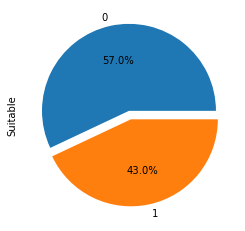

In [17]:
#Examine proportion of Suitable vs. Non-suitable songs
mod_df['Suitable'].value_counts().plot.pie(autopct='%1.1f%%', explode=[0.05, 0.05])

Seems like our data isn't too biased towards one particular class which is a good thing for our analysis.

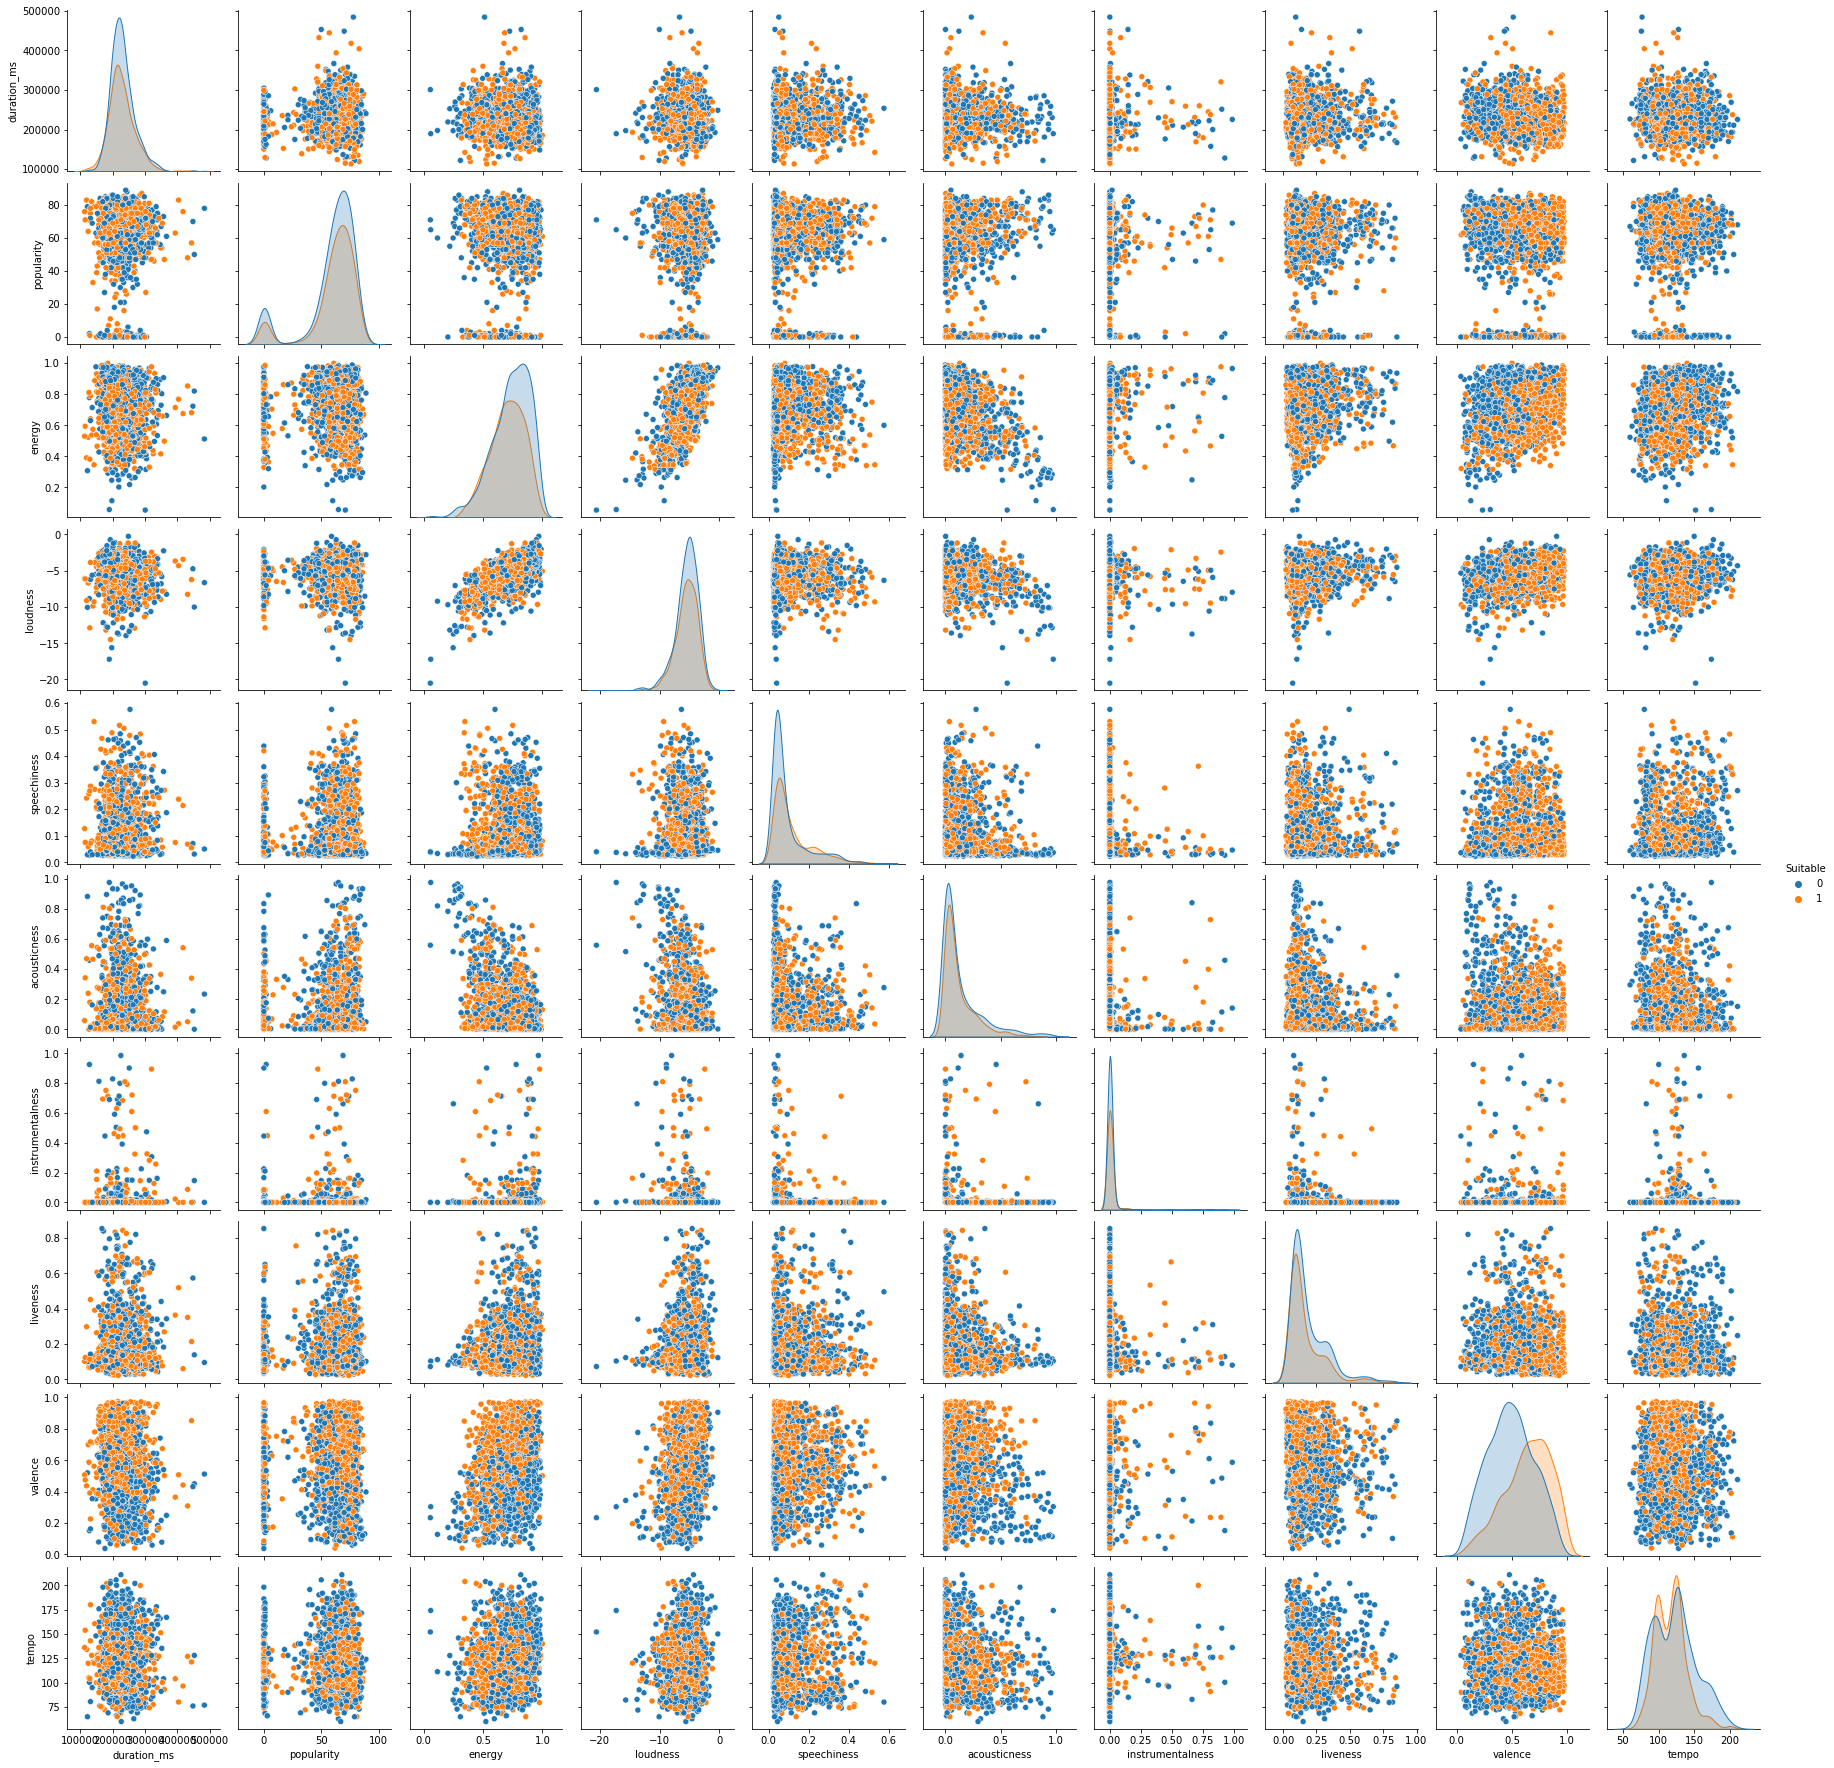

In [18]:
sns.pairplot(df.drop(['explicit','mode'],axis=1),hue='Suitable')

From the pairplots we can see that the target class is mixed and hard to separate in some variable comparisons, while in others there seems to be a trend where our SVM models could separate the classes.

Variable Interactions that seem to be separable: <br>
    (1) valence/duration_ms <br>
    (2) valence/ popularity <br>
    (3) valence/ loudness <br>

In general it looks like the valence plots are the most separable, so valence might be one of the more important features. This will be explored more in the predictive modeling section.

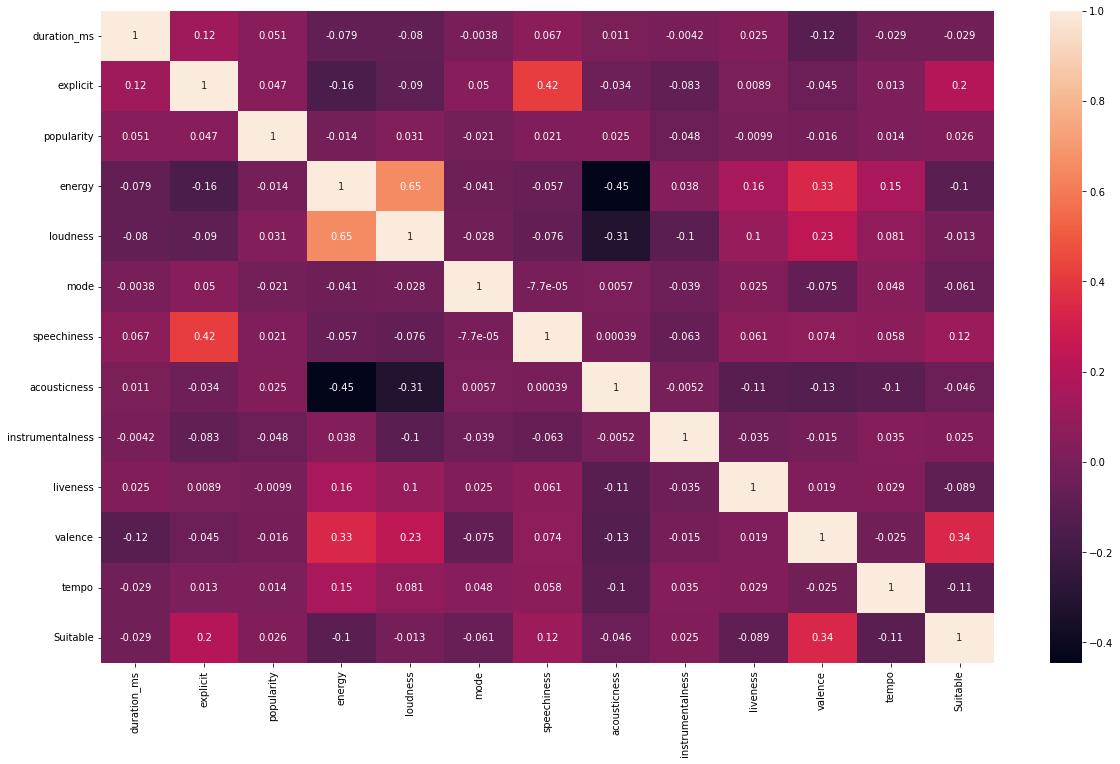

In [19]:
sns.heatmap(data=df.corr(), annot=True)

fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

The correlations based on our df (before adding in the dummies) seem to be okay. There are a couple noteworthy correlations that should be mentioned: <br>

(1) loudness & energy = 0.65 <br>
(2) speechiness & explicit = 0.42 <br>
(3) acousticness & energy = -0.45 <br>

These correlations aren't too worrysome (maybe just loudness and energy). If we find it to be an issue in our predictive modeling section we can try to use Principal Component analysis to work around this. <br>

Note: Valence is the variable most correlated with Suitable which seems to agree with our findings from the pairplots.

## Predictive Modeling

In [20]:
#Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

In [21]:
#Prepping the data for analysis
X = np.array(mod_df.drop('Suitable',axis=1))
Y = np.array(mod_df['Suitable'])

#Split the data
XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(X,Y)

In [22]:
#Scaling the X data
scaler = MinMaxScaler()
scaler.fit(XTRAIN)

XTRAIN = scaler.transform(XTRAIN)
XTEST = scaler.transform(XTEST)

### Linear SVC

In [23]:
SVM=SVC(kernel="linear")
SVM.fit(XTRAIN,YTRAIN)
linear_preds = SVM.predict(XTEST)
print(classification_report(YTEST,linear_preds))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       283
           1       0.69      0.66      0.67       217

    accuracy                           0.72       500
   macro avg       0.72      0.71      0.72       500
weighted avg       0.72      0.72      0.72       500



In [24]:
print(confusion_matrix(YTEST,linear_preds))

[[218  65]
 [ 74 143]]


An accuracy of 73% is okay; we should try some of the other SVM models to see if we can get a better fit! We should also note that this linear SVC model had more false positives than false negatives. This means that if we used this model to make predictions about songs for our friend, they might end up with some non-suitable songs in their bar playlist!

### Radial Basis Function SVM

In [25]:
RBF=SVC(kernel="rbf", gamma=100)
RBF.fit(XTRAIN,YTRAIN)
rbf_preds = RBF.predict(XTEST)
print(classification_report(YTEST,rbf_preds))

              precision    recall  f1-score   support

           0       0.57      1.00      0.73       283
           1       1.00      0.03      0.06       217

    accuracy                           0.58       500
   macro avg       0.79      0.52      0.40       500
weighted avg       0.76      0.58      0.44       500



The results from our first RBF model were worse than the linear. This might be because the parameters chosen were not optimal for our data so we will try a grid search to see if we can improve the performance of our RBF model.

In [26]:
from sklearn.model_selection import GridSearchCV

In [53]:
#Create our parameter grid
param_grid = {'C': [0.1,1,10,100,1000,10000], 
              'gamma': [10,1,0.1,0.01,0.001,0.0001,0.00001],
              'shrinking': [True,False],
              'class_weight': [None,'balanced'],
              'kernel': ['rbf']} 

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=0)

In [54]:
#Takes some time
grid.fit(XTRAIN,YTRAIN)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000, 10000],
                         'class_weight': [None, 'balanced'],
                         'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05],
                         'kernel': ['rbf'], 'shrinking': [True, False]})

In [29]:
#Results from the grid search
grid.best_params_

{'C': 1000,
 'class_weight': None,
 'gamma': 0.001,
 'kernel': 'rbf',
 'shrinking': True}

In [30]:
gridrbf_preds = grid.predict(XTEST)

In [31]:
print(classification_report(YTEST,gridrbf_preds))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76       283
           1       0.69      0.65      0.67       217

    accuracy                           0.72       500
   macro avg       0.72      0.71      0.71       500
weighted avg       0.72      0.72      0.72       500



In [32]:
print(confusion_matrix(YTEST,gridrbf_preds))

[[221  62]
 [ 77 140]]


Although the accuracy for our RBF model is similar to the Linear SVC model, we can see that the balance between false negatives and false positives is a little better in the RBF model which might be a reason to use it over the linear. Let's try a few more models!

### Polynomial SVC

In [33]:
#These parameters were obtained from the grid search below
POLY=SVC(kernel="poly",C=1,degree=3,gamma=0.1,coef0=1,class_weight='balanced')
POLY.fit(XTRAIN,YTRAIN)
poly_preds = POLY.predict(XTEST)
print(classification_report(YTEST,poly_preds))

              precision    recall  f1-score   support

           0       0.77      0.72      0.75       283
           1       0.67      0.71      0.69       217

    accuracy                           0.72       500
   macro avg       0.72      0.72      0.72       500
weighted avg       0.72      0.72      0.72       500



In [34]:
print(confusion_matrix(YTEST,poly_preds))

[[205  78]
 [ 62 155]]


In [35]:
#THIS CODE TAKES A LONG TIME TO RUN ~1 hour
# param_grid2 = {'C': [0.1,1,10,100,1000,10000],
#                'degree': [2,3,4,5,6],
#                'gamma': [1,0.1,0.01,0.001,0.0001],
#                'coef0':[0.1,0,1,2],
#                'shrinking': [True,False],
#                'class_weight': [None,'balanced'],
#                'kernel': ['poly']} 

# grid2 = GridSearchCV(SVC(),param_grid2,refit=True,verbose=2)

#grid2.fit(XTRAIN,YTRAIN)

#Results from the grid search
#grid2.best_params_

After the grid search we were able to obtain an accuracy and confusion matrix similar to our RBF model. This may lead us to believe that the best we can do with SVM methods is around 72%. Let's try one more model!

### Sigmoid SVC

In [36]:
#These parameters were obtained from the grid search below
SIG=SVC(C=10000,kernel="sigmoid",gamma=0.0001,coef0=1,class_weight=None)
SIG.fit(XTRAIN,YTRAIN)
sig_preds = SIG.predict(XTEST)
print(classification_report(YTEST,sig_preds))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       283
           1       0.69      0.66      0.67       217

    accuracy                           0.72       500
   macro avg       0.72      0.72      0.72       500
weighted avg       0.72      0.72      0.72       500



In [37]:
print(confusion_matrix(YTEST,sig_preds))

[[219  64]
 [ 74 143]]


After our grid search for the sigmoid SVC, we were able to tune the model to achieve 73% accuracy. One downside to this model is that is has a higher rate of false positives vs. false negatives like the linear SVC we built earlier. For this reason we will probably not choose to use the sigmoid SVC.

In [38]:
#THIS CODE TAKES ~ 9 MINUTES
# param_grid3 = {'C': [0.1,1,10,100,1000,10000],
#                'gamma': [10,1,0.1,0.01,0.001,0.0001],
#                'coef0':[0,1,2,3],
#                'shrinking': [True,False],
#                'class_weight': [None,'balanced'],
#                'kernel': ['sigmoid']} 

# grid3 = GridSearchCV(SVC(),param_grid3,refit=True,verbose=2)

# grid3.fit(XTRAIN,YTRAIN)

In [39]:
#Results from the grid search
#grid3.best_params_

## Final Model Selection and Testing

Based on the 4 different SVC models we tried, the two best ones were the Radial Basis Function (RBF) and Polynomial SVC (POLY). We will now compare the average performance of these two models based on different train/test splits in order to choose our final model.

In [40]:
#Function for generalizing performance across multiple train/test splits
#Will take some time to run depending on the number of splits

def Avg_Model_Accuracy(X,Y,model,model_name,nsplits,test_size=0.3,kde=False):
    model_acc =[]
    for split in range(nsplits):
        XTRAIN, XTEST, YTRAIN, YTEST=train_test_split(X,Y,test_size=test_size) #Split the data
        
        scaler = MinMaxScaler() #Scale the data for SVC
        scaler.fit(XTRAIN)
        XTRAIN = scaler.transform(XTRAIN)
        XTEST = scaler.transform(XTEST)
        
        model.fit(XTRAIN,YTRAIN) #Fit the model
        YPRED = model.predict(XTEST)
        model_acc.append(accuracy_score(YTEST,YPRED))
        
    model_mean = round(np.mean(model_acc),3)
    model_2sd=round(2*np.std(model_acc),3)
    print(f'{model_name} Mean Accuracy: {model_mean} +/- {model_2sd}')
    
    if kde == True:
        sns.kdeplot(model_acc) #Optional plot

### RBF Model

In [41]:
RBF_final=SVC(C=10000,kernel="rbf",gamma=0.001,class_weight='balanced')

RBF Mean Accuracy: 0.725 +/- 0.032


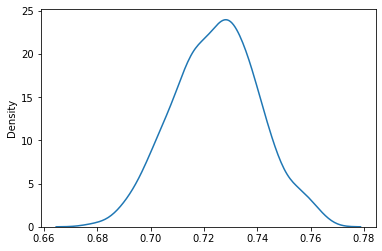

In [42]:
Avg_Model_Accuracy(X,Y,RBF_final,"RBF",nsplits=500,kde=True)

### POLY Model

In [43]:
POLY_final =SVC(kernel="poly",C=1,degree=3,gamma=0.1,coef0=1,class_weight='balanced')

POLY Mean Accuracy: 0.727 +/- 0.031


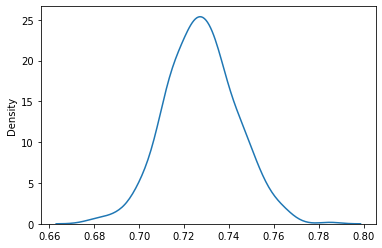

In [44]:
Avg_Model_Accuracy(X,Y,POLY_final,"POLY",nsplits=500,kde=True)

# Conclusions

After gauging the generalized performance of both models, they both seem to be performing around the same level. Since the POLY model performed slightly better we will choose this to be our final model. Let's go ahead and explore the model a bit more before we get back to our bar-owning friend and let them know how we can help them choose suitable songs for their patrons!

---

### Which features were most important for our model?

In [45]:
#Indivual classifications for each feature to compare affect on accuracy.

#For Xdata we pass in a feature dataframe

def feature_accuracy(Xdata,Y,model,test_size=0.3,top_features=5):
    feat_accs = {}
    
    for i in range(len(Xdata.columns)):
        X = np.array(Xdata[Xdata.columns[i]]).reshape(-1,1)
        XTRAIN, XTEST, YTRAIN, YTEST=train_test_split(X,Y,test_size=test_size,random_state=420,shuffle=True)
        
        scaler = MinMaxScaler() #Scale the data for SVC
        scaler.fit(XTRAIN)
        XTRAIN = scaler.transform(XTRAIN)
        XTEST = scaler.transform(XTEST)
        
        model.fit(XTRAIN,YTRAIN) #Fit the model
        YPRED = model.predict(XTEST)
        
        accuracy = np.round(accuracy_score(YTEST,YPRED),3)
        feature_name=Xdata.columns[i]
        
        feat_accs[str(feature_name)] = accuracy
    #Returns a dictionary of features and their accuracies
    
    acc_df = pd.DataFrame(columns=['Feature','Accuracy']) #Create empty dataframe for top features/accuracies
    for j in range(top_features):
        max_value = max(feat_accs.values()) #Highest accuracy in dictionary
        max_key= max(feat_accs, key=feat_accs.get) #Feature name with highest accuracy
        
        acc_df.loc[len(acc_df)] = [max_key,max_value] #Insert new row into our dataframe
    
        feat_accs.pop(max_key) #Remove the feature we just added so it does not get selected again
        
    return acc_df #Dataframe of top features

In [46]:
#Display the top 10 features for our model
#POLY
feature_accuracy(mod_df.drop('Suitable',axis=1),Y,POLY_final,top_features=10)

,Feature,Accuracy
0,valence,0.643
1,explicit,0.632
2,hip hop,0.625
3,r&b,0.600
4,speechiness,0.598
5,2018,0.595
6,Key Value_1,0.595
7,2004,0.580
8,latin,0.578
9,2002,0.577


<AxesSubplot:xlabel='Feature', ylabel='Accuracy'>

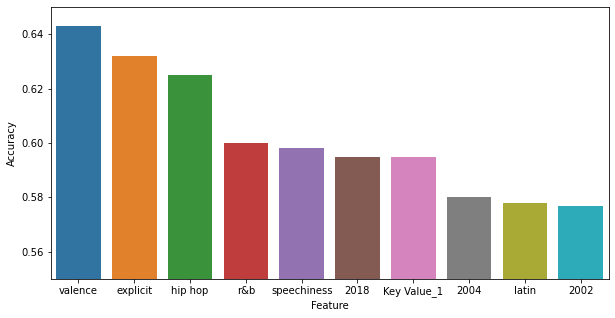

In [47]:
#Visualizing individual feature performance
top_feats = feature_accuracy(mod_df.drop('Suitable',axis=1),Y,POLY_final,top_features=10)

plt.figure(figsize = (10,5))
plt.ylim(0.55,0.65)
sns.barplot(x='Feature',y='Accuracy',data=top_feats)

As we anticipated from our initial exploratory analysis, valence was the top contributor to accurate predictions. It is interesting that the second best feature was if the song was considered 'explicit' or not! We can also see that some of our dummy variables are outperforming some of the base features. Noteable genres were hip hop, r&b, and latin which makes sense in the context of a "danceable" song. Interestly we also had some years pop up as top features (2018,2004,2002). 

## How much did our engineered features help the analysis?

Before we offer our final conclusion to our bar-owning friend, let's take a look at how our model would perform on the base dataset without some of the engineered features. This will give us an idea of how useful it was to breakup the years, key, and genre columns.

In [48]:
#Prep base dataset
base_df = pd.read_csv('songs_normalize.csv')

#Create a column for our target class: Suitable vs. Non-suitable
base_df['Suitable'] = [1 if num >= 0.7 else 0 for num in base_df['danceability']]

#Bool to binary for 'explicit'
base_df['explicit'] = [1 if entry == True else 0 for entry in base_df['explicit']]

base_df.drop(['danceability','artist','song','key','year','genre'],axis=1,inplace=True)

In [49]:
base_df.head(3)

,duration_ms,explicit,popularity,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,Suitable
0,211160,0,77,0.834,-5.444,0,0.0437,0.3000,0.000018,0.355,0.894,95.053,1
1,167066,0,79,0.897,-4.918,1,0.0488,0.0103,0.000000,0.612,0.684,148.726,0
2,250546,0,66,0.496,-9.007,1,0.0290,0.1730,0.000000,0.251,0.278,136.859,0


In [50]:
x = np.array(base_df.drop('Suitable',axis=1))
y = np.array(base_df['Suitable'])

In [51]:
# Just a reminder of our final model
# POLY_final =SVC(kernel="poly",C=1,degree=3,gamma=0.1,coef0=1,class_weight='balanced')

In [52]:
Avg_Model_Accuracy(x,y,POLY_final,"base_df",nsplits=500)
Avg_Model_Accuracy(X,Y,POLY_final,"feature_engineered_df",nsplits=500)

base_df Mean Accuracy: 0.703 +/- 0.032
feature_engineered_df Mean Accuracy: 0.728 +/- 0.03


Based on the results of our Avg_Model_Accuracy function, we can see that including the engineered features improved the accuracy by about 2%. This isn't the greatest of improvements but not much work goes into extracting those features if we continue to get song data in the form of this dataset, so we should suggest using the engineered features when making predicitons about new data points.

# Final Words

Now that we've gone through our dataset and tried some different models, we can recommend the use of our Polynomial Support Vector Classifier for their business. The following must be performed on any new data: <br>

(1) Extract features/create dummy variables <br>
(2) Scale the data <br>
(3) Make predictions with the model <br>

With this model, we can expect around 72% of the songs to be considered 'Suitable' for our bar-owning friend's clientelle. Since our model's accuracy was still relatively low, we would also suggest that the bar-owner collect data from their patrons about new songs that were chosen as 'Suitable', and see if it was preferred or disliked. Since taste in music is subjective, it will be up to the owner to make decisions about what genres to include in their playlists and pay close attention to the response from their guests. Hopefully this model helps bring great music to their bar!

---

### If you enjoyed the notebook or have any questions regarding the methods of the analysis, please feel free to leave a comment! Thank you!!